# Catboost

In [1]:
import numpy as np
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath(os.path.join("..", "..", "src")))
from helpers import add_cell_timer
from pipeline import ModelPipeline
add_cell_timer()

data_file = "../../data/subset_transactions2.csv"

## Data preprocessing

In [2]:
pl = ModelPipeline(data_file)


⏱️ Execution time: 1.62s


In [3]:
pl.rename_columns()
pl.drop_duplicates()
pl.create_unique_ids()
pl.currency_normalization()
pl.extract_time_features()
pl.cyclical_encoding()
pl.binary_weekend()
pl.apply_label_encoding()
pl.apply_one_hot_encoding()

Creating unique ids...

Normalizing currency...

Extracting time features...

Adding cyclical encoding to time feats...

Applying label encoding...

Label encoding applied to columns: ['day_of_week', 'from_bank', 'to_bank']

Applying one hot encoding...

c:\Users\sophi\anaconda3\envs\capstone_env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
c:\Users\sophi\anaconda3\envs\capstone_env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


One hot encoding applied to columns: ['payment_type', 'received_currency', 'sent_currency']


⏱️ Execution time: 27.95s


In [4]:
pl.df.drop(columns=['from_bank', 'to_bank'], inplace=True)
pl.df.head()

,received_amount,sent_amount,is_laundering,from_account_id,to_account_id,from_account_idx,to_account_idx,sent_amount_usd,received_amount_usd,hour_of_day,...,sent_currency_US Dollar,sent_currency_Yen,sent_currency_Yuan,payment_type_ACH,payment_type_Bitcoin,payment_type_Cash,payment_type_Cheque,payment_type_Credit Card,payment_type_Reinvestment,payment_type_Wire
0,3697.34,3697.34,0,10_8000EBD30,10_8000EBD30,0,0,3697.34,3697.34,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.01,0.01,0,3208_8000F4580,1_8000F5340,1,81239,0.01,0.01,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2806.97,2806.97,0,12_8000F5030,12_8000F5030,2,2,2806.97,2806.97,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36682.97,36682.97,0,10_8000F5200,10_8000F5200,3,3,36682.97,36682.97,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,6162.44,6162.44,0,1_8000F5AD0,1_8000F5AD0,4,4,6162.44,6162.44,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0



⏱️ Execution time: 0.48s


In [5]:
pl.df.columns

Index(['received_amount', 'sent_amount', 'is_laundering', 'from_account_id',
       'to_account_id', 'from_account_idx', 'to_account_idx',
       'sent_amount_usd', 'received_amount_usd', 'hour_of_day', 'day_of_week',
       'seconds_since_midnight', 'timestamp_int', 'timestamp_scaled',
       'day_sin', 'day_cos', 'time_of_day_sin', 'time_of_day_cos',
       'is_weekend', 'received_currency_Australian Dollar',
       'received_currency_Bitcoin', 'received_currency_Brazil Real',
       'received_currency_Canadian Dollar', 'received_currency_Euro',
       'received_currency_Mexican Peso', 'received_currency_Ruble',
       'received_currency_Rupee', 'received_currency_Saudi Riyal',
       'received_currency_Shekel', 'received_currency_Swiss Franc',
       'received_currency_UK Pound', 'received_currency_US Dollar',
       'received_currency_Yen', 'received_currency_Yuan',
       'sent_currency_Australian Dollar', 'sent_currency_Bitcoin',
       'sent_currency_Brazil Real', 'sent_currency


⏱️ Execution time: 0.0s


### Add degree centrality and pagerank

In [6]:
pl.extract_nodes(add_graph_features=True)

Extracting nodes...

Creating a Data Frame containing 107583 nodes

Extracting graph features...

Graph features computed using: ['sent_amount', 'received_amount']

**Note**, previously graph-based features were calculated using only `sent_amount` as edge weight (only based on 
outgoing transactions). Now both sent and received amounts are included by default.

New feature columns added: degree_centrality, in_degree_centrality, out_degree_centrality, pagerank_sent_amount, 
pagerank_received_amount


⏱️ Execution time: 10.16s


In [7]:
pl.nodes.columns

Index(['node_id', 'degree_centrality', 'in_degree_centrality',
       'out_degree_centrality', 'pagerank_sent_amount',
       'pagerank_received_amount'],
      dtype='object')


⏱️ Execution time: 0.02s


In [8]:
# Merge sender node features
pl.df = pl.df.merge(pl.nodes, how='left', left_on='from_account_idx', right_on='node_id', suffixes=('', '_sender'))

# Merge receiver node features
pl.df = pl.df.merge(pl.nodes, how='left', left_on='to_account_idx', right_on='node_id', suffixes=('', '_receiver'))

# Drop duplicate node_id columns if needed
pl.df.drop(columns=['node_id', 'node_id_receiver','from_account_id', 'to_account_id'], inplace=True)


⏱️ Execution time: 1.91s


In [9]:
pl.df.columns

Index(['received_amount', 'sent_amount', 'is_laundering', 'from_account_idx',
       'to_account_idx', 'sent_amount_usd', 'received_amount_usd',
       'hour_of_day', 'day_of_week', 'seconds_since_midnight', 'timestamp_int',
       'timestamp_scaled', 'day_sin', 'day_cos', 'time_of_day_sin',
       'time_of_day_cos', 'is_weekend', 'received_currency_Australian Dollar',
       'received_currency_Bitcoin', 'received_currency_Brazil Real',
       'received_currency_Canadian Dollar', 'received_currency_Euro',
       'received_currency_Mexican Peso', 'received_currency_Ruble',
       'received_currency_Rupee', 'received_currency_Saudi Riyal',
       'received_currency_Shekel', 'received_currency_Swiss Franc',
       'received_currency_UK Pound', 'received_currency_US Dollar',
       'received_currency_Yen', 'received_currency_Yuan',
       'sent_currency_Australian Dollar', 'sent_currency_Bitcoin',
       'sent_currency_Brazil Real', 'sent_currency_Canadian Dollar',
       'sent_currency_Eu


⏱️ Execution time: 0.02s


# Feature importance

### Split data into train-val-test

In [10]:
pl.df = pl.df.sort_values(by='timestamp_int')
pl.df = pl.df.reset_index(drop=True)
pl.df['edge_id'] = pl.df.index
X_cols = ['edge_id','received_amount', 'sent_amount','from_account_idx',
       'to_account_idx', 'sent_amount_usd', 'received_amount_usd',
       'hour_of_day', 'day_of_week', 'seconds_since_midnight', 'timestamp_int',
       'timestamp_scaled', 'day_sin', 'day_cos', 'time_of_day_sin',
       'time_of_day_cos', 'is_weekend', 'received_currency_Australian Dollar',
       'received_currency_Bitcoin', 'received_currency_Brazil Real',
       'received_currency_Canadian Dollar', 'received_currency_Euro',
       'received_currency_Mexican Peso', 'received_currency_Ruble',
       'received_currency_Rupee', 'received_currency_Saudi Riyal',
       'received_currency_Shekel', 'received_currency_Swiss Franc',
       'received_currency_UK Pound', 'received_currency_US Dollar',
       'received_currency_Yen', 'received_currency_Yuan',
       'sent_currency_Australian Dollar', 'sent_currency_Bitcoin',
       'sent_currency_Brazil Real', 'sent_currency_Canadian Dollar',
       'sent_currency_Euro', 'sent_currency_Mexican Peso',
       'sent_currency_Ruble', 'sent_currency_Rupee',
       'sent_currency_Saudi Riyal', 'sent_currency_Shekel',
       'sent_currency_Swiss Franc', 'sent_currency_UK Pound',
       'sent_currency_US Dollar', 'sent_currency_Yen', 'sent_currency_Yuan',
       'payment_type_ACH', 'payment_type_Bitcoin', 'payment_type_Cash',
       'payment_type_Cheque', 'payment_type_Credit Card',
       'payment_type_Reinvestment', 'payment_type_Wire', 'degree_centrality',
       'in_degree_centrality', 'out_degree_centrality', 'pagerank_sent_amount',
       'pagerank_received_amount', 
       'degree_centrality_receiver', 'in_degree_centrality_receiver',
       'out_degree_centrality_receiver', 'pagerank_sent_amount_receiver',
       'pagerank_received_amount_receiver']
y_col = 'is_laundering'
X_train, X_val, X_test, y_train, y_val, y_test = pl.split_train_test_val(X_cols, y_col, test_size=0.20, val_size=0, split_type='temporal')

Data split using temporal method.


⏱️ Execution time: 1.61s


In [11]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

1000720
0
250181

⏱️ Execution time: 0.02s


Rescale numerical features:

In [12]:
from sklearn.preprocessing import StandardScaler
def numerical_scaling(numerical_features):
    """Standardize Numerical Features"""

    std_scaler = StandardScaler()

    pl.X_train[numerical_features] = std_scaler.fit_transform(pl.X_train[numerical_features])
    pl.X_test[numerical_features] = std_scaler.transform(pl.X_test[numerical_features])

    return pl.X_train, pl.X_test

numerical_feats = ['sent_amount_usd', 'received_amount_usd', 'timestamp_scaled']
X_train, X_test = numerical_scaling(numerical_feats)


⏱️ Execution time: 0.11s


## Logistic regression feature selection

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# --- Define PR AUC Scorer ---
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

# --- Base Model (all features) ---
base_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear', max_iter=1000)
)
base_model.fit(X_train, y_train)

# Evaluate PR AUC on validation set
base_pr_auc = average_precision_score(y_test, base_model.predict_proba(X_test)[:, 1])
print(f"PR AUC (all features): {base_pr_auc:.4f}")

# --- RFE for Feature Selection ---
# Use cross-validation to select best features via PR AUC
logreg = LogisticRegression(solver='liblinear', max_iter=1000)

rfe = RFE(logreg, n_features_to_select=20)  # or leave blank and tune n later
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected features:", list(selected_features))

# Retrain logistic regression on selected features
selected_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear', max_iter=1000)
)
selected_model.fit(X_train[selected_features], y_train)

# Evaluate PR AUC
selected_pr_auc = average_precision_score(
    y_test,
    selected_model.predict_proba(X_test[selected_features])[:, 1]
)
print(f"PR AUC (selected features): {selected_pr_auc:.4f}")


PR AUC (all features): 0.1117
Selected features: ['edge_id', 'received_amount', 'sent_amount', 'from_account_idx', 'to_account_idx', 'hour_of_day', 'day_of_week', 'seconds_since_midnight', 'timestamp_int', 'day_sin', 'day_cos', 'time_of_day_sin', 'time_of_day_cos', 'is_weekend', 'sent_currency_Saudi Riyal', 'payment_type_ACH', 'payment_type_Cash', 'payment_type_Cheque', 'payment_type_Credit Card', 'payment_type_Reinvestment']
PR AUC (selected features): 0.0980

⏱️ Execution time: 601.86s


In [ ]:
# Extract the trained logistic regression model from the pipeline
logreg_model = base_model.named_steps['logisticregression']  # or selected_model.named_steps['logisticregression']

# Get coefficients
coefs = pd.Series(logreg_model.coef_[0], index=X_train.columns)
print(coefs)

# Extract the trained logistic regression model from the pipeline
logreg_model = selected_model.named_steps['logisticregression']  # or selected_model.named_steps['logisticregression']

# Get coefficients
coefs = pd.Series(logreg_model.coef_[0], index=X_train.columns)
print(coefs)

## Train initial XGboost model and perform SHAP

In [18]:
import xgboost as xgb

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',  # since you're tracking PR AUC
    use_label_encoder=False,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

c:\Users\sophi\anaconda3\envs\capstone_env\lib\site-packages\xgboost\core.py:158: UserWarning: [08:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


⏱️ Execution time: 7.28s


In [19]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

: 

# Perform backward selection

In [ ]:
from datetime import datetime
import json
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_recall_curve, auc

def evaluate_model(features, X_train, y_train, X_val, y_val, cat_features):
    """Train a CatBoost model and return the validation PR AUC."""
    candidate_cat_features = [f for f in cat_features if f in features]
    train_pool = Pool(X_train[features], y_train, cat_features=candidate_cat_features)
    val_pool = Pool(X_val[features], y_val, cat_features=candidate_cat_features)

    model = CatBoostClassifier(
        iterations=1000,
        depth=8,
        learning_rate=0.05,
        loss_function='Logloss',
        eval_metric='F1',
        class_weights={0: 1, 1: 12},
        random_seed=42,
        silent=True
    )
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=False)

    y_val_proba = model.predict_proba(X_val[features])[:, 1]
    precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_val_proba)
    return auc(recall_vals, precision_vals)


def run_backward_selection(pl, X_train, y_train, X_val, y_val, X_test, y_test):
    
    # Setup: get current categorical features
    cat_features = X_train.select_dtypes(include=["category"]).columns.tolist()
    current_features = list(X_train.columns)
    current_best_auc = evaluate_model(current_features, X_train, y_train, X_val, y_val, cat_features)
    print(f"Baseline Validation PR AUC with all features: {current_best_auc:.4f}")

    improvement = True
    while improvement and len(current_features) > 1:
        improvement = False
        best_auc_candidate = current_best_auc
        feature_to_remove = None

        for feat in current_features:
            candidate_features = [f for f in current_features if f != feat]
            try:
                candidate_auc = evaluate_model(candidate_features, X_train, y_train, X_val, y_val, cat_features)
            except Exception as e:
                print(f"Error removing {feat}: {e}")
                continue
            print(f"Removing {feat}: Validation PR AUC = {candidate_auc:.4f}")
            if candidate_auc > best_auc_candidate:
                best_auc_candidate = candidate_auc
                feature_to_remove = feat

        if feature_to_remove:
            print(f"✅ Removed {feature_to_remove}, PR AUC improved from {current_best_auc:.4f} to {best_auc_candidate:.4f}")
            current_features.remove(feature_to_remove)
            current_best_auc = best_auc_candidate
            improvement = True
        else:
            print("No more improvement.")

    print("\n🎯 Final selected features:")
    print(current_features)

    # Final training on train + val
    X_train_final = pd.concat([X_train, X_val])
    y_train_final = pd.concat([y_train, y_val])
    final_cat_features = [f for f in cat_features if f in current_features]

    train_pool = Pool(X_train_final[current_features], y_train_final, cat_features=final_cat_features)
    test_pool = Pool(X_test[current_features], y_test, cat_features=final_cat_features)

    final_model = CatBoostClassifier(
        iterations=1000,
        depth=8,
        learning_rate=0.05,
        loss_function='Logloss',
        eval_metric='F1',
        class_weights={0: 1, 1: 12},
        random_seed=42,
        silent=True
    )
    final_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=100)

    # Evaluate on test
    y_train_pred = final_model.predict(X_train[current_features])
    y_train_proba = final_model.predict_proba(X_train[current_features])

    y_val_pred = final_model.predict(X_val[current_features])
    y_val_proba = final_model.predict_proba(X_val[current_features])

    y_test_pred = final_model.predict(X_test[current_features])
    y_test_proba = final_model.predict_proba(X_test[current_features])

    pl.result_metrics(
        slide_title="Final CatBoost Model Performance (Backward Feature Selection)",
        y_train=y_train,
        y_train_pred=y_train_pred,
        y_train_proba=y_train_proba,
        y_val=y_val,
        y_val_pred=y_val_pred,
        y_val_proba=y_val_proba,
        y_test=y_test,
        y_test_pred=y_test_pred,
        y_test_proba=y_test_proba
    )

    # Save final model + metrics
    final_model_path = "out/catboost_final_model.cbm"
    final_model.save_model(final_model_path)

    print(f"✅ Final model trained and saved to {final_model_path}")

Baseline Validation PR AUC with all features: 0.7193
Removing TransactionID: Validation PR AUC = 0.7068
Removing from_bank: Validation PR AUC = 0.7156
Removing to_bank: Validation PR AUC = 0.7192
Removing received_amount: Validation PR AUC = 0.7207
Removing received_currency: Validation PR AUC = 0.7004
Removing sent_amount: Validation PR AUC = 0.7163
Removing sent_currency: Validation PR AUC = 0.7018
Removing payment_type: Validation PR AUC = 0.6819
Removing from_account_id: Validation PR AUC = 0.6696
Removing to_account_id: Validation PR AUC = 0.6830
Removing received_amount_min: Validation PR AUC = 0.7066
Removing received_amount_max: Validation PR AUC = 0.7143
Removing received_amount_std: Validation PR AUC = 0.7108
Removing hour_of_day: Validation PR AUC = 0.7092
Removing day_of_week: Validation PR AUC = 0.7143
Removing day_sin: Validation PR AUC = 0.7170
Removing day_cos: Validation PR AUC = 0.7160
Removing time_of_day_sin: Validation PR AUC = 0.7210
Removing time_of_day_cos: Vali

CatBoostError: (Error 2: No such file or directory) util/system/file.cpp:936: can't open "/Users/zoujingyi/Desktop/EDA/catboost_final_model.cbm" with mode WrOnly|CreateAlways|Seq (0x00000034)

# Output of Final Model

/var/folders/w4/n_bv35wx6x5f2xtcncjg_g3r0000gn/T/ipykernel_69553/892271275.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/var/folders/w4/n_bv35wx6x5f2xtcncjg_g3r0000gn/T/ipykernel_69553/892271275.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
/var/folders/w4/n_bv35wx6x5f2xtcncjg_g3r0000gn/T/ipykernel_69553/892271275.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

0:	learn: 0.3549343	test: 0.3775722	best: 0.3775722 (0)	total: 537ms	remaining: 8m 56s
100:	learn: 0.8094310	test: 0.7973422	best: 0.7990040 (98)	total: 24.5s	remaining: 3m 38s
200:	learn: 0.8348433	test: 0.8143364	best: 0.8143364 (200)	total: 48.6s	remaining: 3m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8155763807
bestIteration = 218

Shrink model to first 219 iterations.


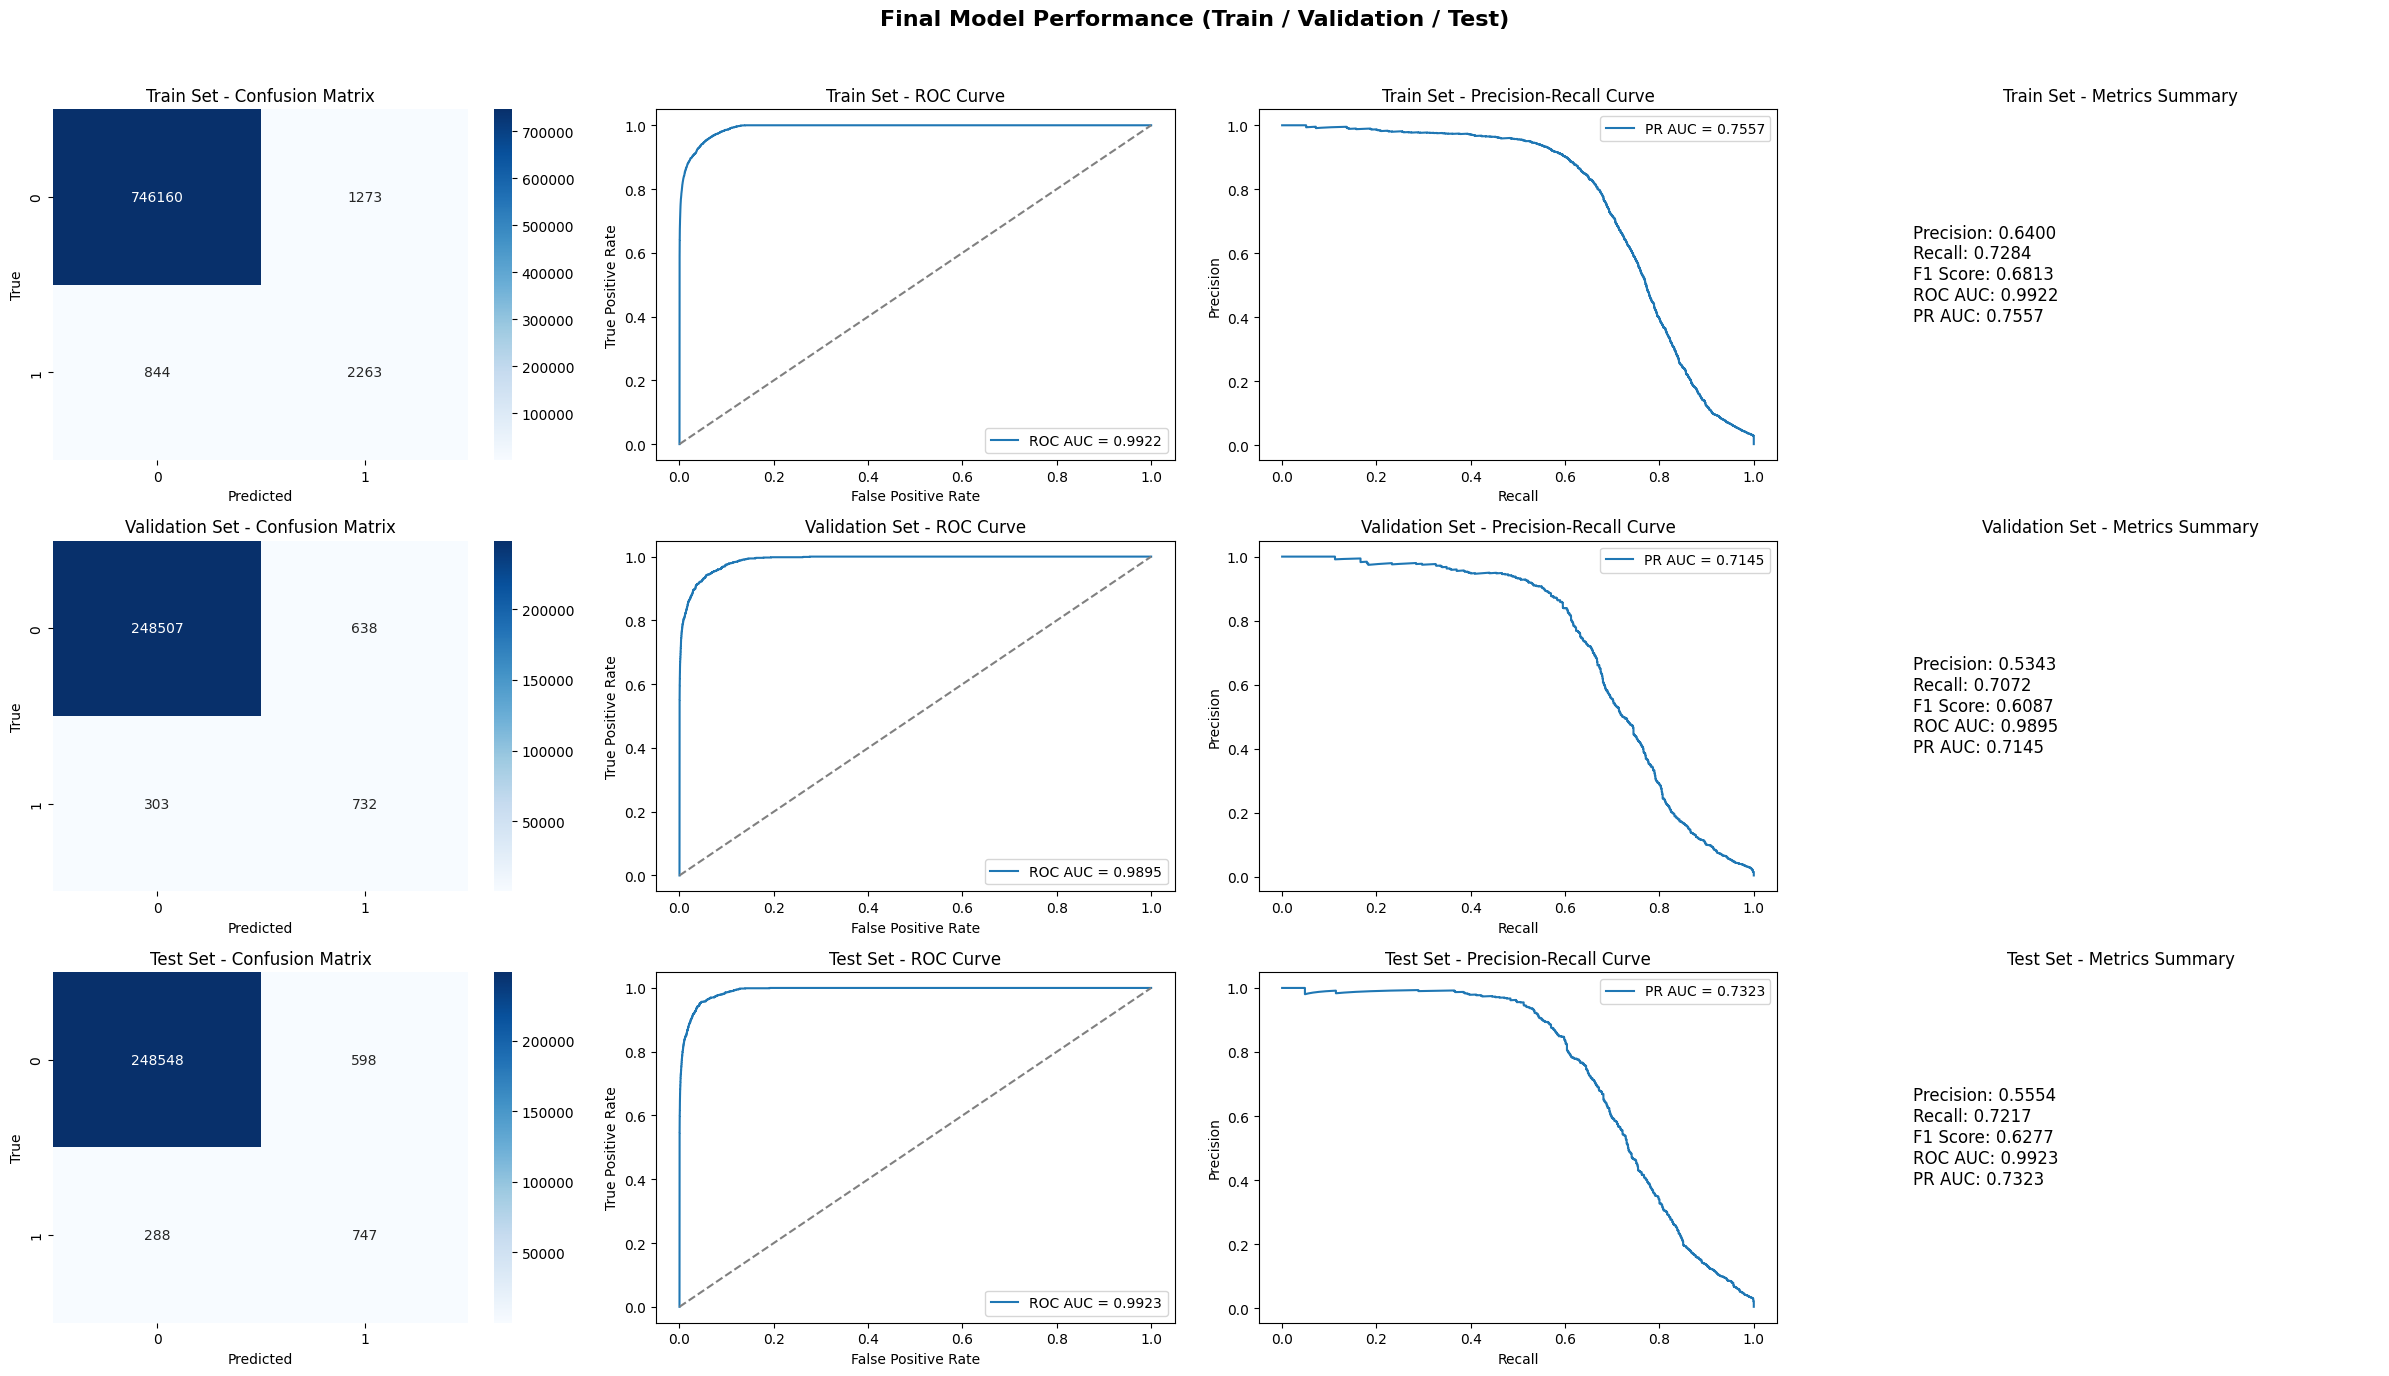

✅ Final model plots saved at: /Users/zoe_mac/Desktop/EDA/final_model_plots.png
✅ Final model trained and saved.
Final Test Set Performance:
Precision: 0.5554
Recall: 0.7217
F1 Score: 0.6277
PR AUC: 0.7323
ROC AUC: 0.9923
Confusion Matrix:
 [[248548, 598], [288, 747]]


<Figure size 640x480 with 0 Axes>

In [33]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, json
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, f1_score,
                             roc_curve, roc_auc_score, precision_recall_curve, auc)
from catboost import CatBoostClassifier, Pool

# ---------------------------
# Utility Functions
# ---------------------------
def compute_metrics(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc, pr_auc = None, None
    fpr, tpr, prec_curve, rec_curve = None, None, None, None
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = roc_auc_score(y_true, y_prob)
        prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(rec_curve, prec_curve)
    return {
        'cm': cm,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'precision_curve': prec_curve,
        'recall_curve': rec_curve,
        'pr_auc': pr_auc
    }

def plot_results_3rows_4cols(train_metrics, val_metrics, test_metrics,
                             title="Final Model Performance (Train / Validation / Test)"):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 14))
    fig.suptitle(title, fontsize=16, fontweight="bold")

    dataset_names = ["Train Set", "Validation Set", "Test Set"]
    metrics_list = [train_metrics, val_metrics, test_metrics]

    for row_idx, (name, metrics) in enumerate(zip(dataset_names, metrics_list)):
        cm = metrics['cm']
        # Column 0: Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row_idx, 0])
        axes[row_idx, 0].set_title(f"{name} - Confusion Matrix")
        axes[row_idx, 0].set_xlabel("Predicted")
        axes[row_idx, 0].set_ylabel("True")

        # Column 1: ROC Curve
        if metrics['roc_auc'] is not None:
            fpr, tpr = metrics['fpr'], metrics['tpr']
            axes[row_idx, 1].plot(fpr, tpr, label=f"ROC AUC = {metrics['roc_auc']:.4f}")
            axes[row_idx, 1].plot([0,1],[0,1],'--', color='gray')
            axes[row_idx, 1].set_title(f"{name} - ROC Curve")
            axes[row_idx, 1].set_xlabel("False Positive Rate")
            axes[row_idx, 1].set_ylabel("True Positive Rate")
            axes[row_idx, 1].legend()
        else:
            axes[row_idx, 1].set_title(f"{name} - No Probabilities")
            axes[row_idx, 1].axis("off")

        # Column 2: Precision-Recall Curve
        if metrics['pr_auc'] is not None:
            prec_curve = metrics['precision_curve']
            rec_curve = metrics['recall_curve']
            axes[row_idx, 2].plot(rec_curve, prec_curve, label=f"PR AUC = {metrics['pr_auc']:.4f}")
            axes[row_idx, 2].set_title(f"{name} - Precision-Recall Curve")
            axes[row_idx, 2].set_xlabel("Recall")
            axes[row_idx, 2].set_ylabel("Precision")
            axes[row_idx, 2].legend()
        else:
            axes[row_idx, 2].set_title(f"{name} - No Probabilities")
            axes[row_idx, 2].axis("off")

        # Column 3: Text Summary
        text_str = (
            f"Precision: {metrics['precision']:.4f}\n"
            f"Recall: {metrics['recall']:.4f}\n"
            f"F1 Score: {metrics['f1']:.4f}\n"
        )
        if metrics['roc_auc'] is not None:
            text_str += f"ROC AUC: {metrics['roc_auc']:.4f}\n"
        if metrics['pr_auc'] is not None:
            text_str += f"PR AUC: {metrics['pr_auc']:.4f}\n"
        axes[row_idx, 3].text(0.1, 0.5, text_str, fontsize=12, va='center')
        axes[row_idx, 3].set_title(f"{name} - Metrics Summary")
        axes[row_idx, 3].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ---------------------------
# Main Pipeline: Retrain Model using Final Selected Features and Plot Performance
# ---------------------------
def main():
    # Define final selected features
    final_features = [
        'TransactionID', 'from_bank', 'to_bank', 'received_amount', 'received_currency',
        'sent_amount', 'sent_currency', 'payment_type', 'from_account_id', 'to_account_id',
        'received_amount_min', 'received_amount_max', 'received_amount_std',
        'hour_of_day', 'day_of_week', 'day_sin', 'time_of_day_sin', 'time_of_day_cos',
        'timestamp_int', 'degree_centrality', 'pagerank'
    ]

    # ---------------------------
    # A. Load & Preprocess Data
    # ---------------------------
    file_path = "/Users/zoe_mac/Desktop/EDA/subset_agg_txn.csv"
    df = pd.read_csv(file_path)

    # Convert timestamp to datetime and extract time-based features
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.weekday
    df['seconds_since_midnight'] = (df['timestamp'].dt.hour * 3600 +
                                    df['timestamp'].dt.minute * 60 +
                                    df['timestamp'].dt.second)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['time_of_day_sin'] = np.sin(2 * np.pi * df['seconds_since_midnight'] / 86400)
    df['time_of_day_cos'] = np.cos(2 * np.pi * df['seconds_since_midnight'] / 86400)
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['timestamp_int'] = df['timestamp'].astype(np.int64) // 10**9

    # Currency Conversion (rename column to match final_features)
    usd_conversion = {'USD': 1.0, 'EUR': 1.1, 'GBP': 1.3, 'JPY': 0.009}
    if 'Amount Received' in df.columns and 'Receiving Currency' in df.columns:
        df['received_amount'] = df.apply(
            lambda row: row['Amount Received'] / usd_conversion.get(row['Receiving Currency'], 1.0),
            axis=1
        )

    # Graph-based Features using from_account_id and to_account_id
    G = nx.DiGraph()
    for _, row in df.iterrows():
        if pd.notna(row.get('from_account_id')) and pd.notna(row.get('to_account_id')):
            weight = row.get('received_amount', 1)
            G.add_edge(row['from_account_id'], row['to_account_id'], weight=weight)
    deg_cent = nx.degree_centrality(G)
    prank = nx.pagerank(G)
    df['degree_centrality'] = df['from_account_id'].map(deg_cent).fillna(0)
    df['pagerank'] = df['from_account_id'].map(prank).fillna(0)

    # Drop raw columns not in final_features
    drop_cols = ['timestamp', 'seconds_since_midnight', 'is_weekend']
    df.drop(columns=drop_cols, inplace=True, errors='ignore')

    # Ensure TransactionID exists. If not, create it by resetting index.
    if 'TransactionID' not in df.columns:
        df = df.reset_index().rename(columns={'index': 'TransactionID'})

    # Standardize numerical features (exclude target column)
    target_col = 'is_laundering'
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Define X and y. Use only the final features that are available.
    available_features = [f for f in final_features if f in df.columns]
    X = df[available_features]
    y = df[target_col]

    # Convert any remaining object columns to category dtype
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = X[col].astype('category')

    # ---------------------------
    # B. Split Data (60% train, 20% validation, 20% test)
    # ---------------------------
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )

    # Identify categorical features for CatBoost
    cat_features = X_train.select_dtypes(include=['category']).columns.tolist()

    # ---------------------------
    # C. Train Final CatBoost Model using all final features
    # ---------------------------
    train_pool_final = Pool(X_train, y_train, cat_features=cat_features)
    test_pool_final = Pool(X_test, y_test, cat_features=cat_features)

    final_model = CatBoostClassifier(
        iterations=1000,
        depth=8,
        learning_rate=0.05,
        loss_function='Logloss',
        eval_metric='F1',
        class_weights={0: 1, 1: 12},
        random_seed=42,
        silent=True
    )

    # Use early stopping on the test set (or validation, as desired)
    final_model.fit(train_pool_final, eval_set=test_pool_final, early_stopping_rounds=50, verbose=100)

    # ---------------------------
    # D. Compute Performance Metrics for Train, Validation, and Test Sets
    # ---------------------------
    # Train metrics
    y_train_pred_final = final_model.predict(X_train)
    y_train_prob_final = final_model.predict_proba(X_train)[:, 1]
    train_metrics_final = compute_metrics(y_train, y_train_pred_final, y_train_prob_final)

    # Validation metrics
    y_val_pred_final = final_model.predict(X_val)
    y_val_prob_final = final_model.predict_proba(X_val)[:, 1]
    val_metrics_final = compute_metrics(y_val, y_val_pred_final, y_val_prob_final)

    # Test metrics
    y_test_pred_final = final_model.predict(X_test)
    y_test_prob_final = final_model.predict_proba(X_test)[:, 1]
    test_metrics_final = compute_metrics(y_test, y_test_pred_final, y_test_prob_final)

    # ---------------------------
    # E. Plot Performance Results
    # ---------------------------
    plot_results_3rows_4cols(train_metrics_final, val_metrics_final, test_metrics_final,
                             title="Final Model Performance (Train / Validation / Test)")

    final_plot_path = "/Users/zoe_mac/Desktop/EDA/final_model_plots.png"
    plt.savefig(final_plot_path)
    print(f"✅ Final model plots saved at: {final_plot_path}")

    # ---------------------------
    # F. Save Final Model and Metrics
    # ---------------------------
    final_model_path = "/Users/zoe_mac/Desktop/EDA/catboost_final_model.cbm"
    final_model.save_model(final_model_path)

    final_metric_file_path = "/Users/zoe_mac/Desktop/EDA/final_model_performance.json"
    final_metrics_json = {
        "time_stamp": datetime.now().strftime("%d-%m-%Y_%H:%M:%S"),
        "selected_features": available_features,
        "test_confusion_matrix": test_metrics_final['cm'].tolist(),
        "test_precision": test_metrics_final['precision'],
        "test_recall": test_metrics_final['recall'],
        "test_f1_score": test_metrics_final['f1'],
        "test_pr_auc": test_metrics_final['pr_auc'],
        "test_roc_auc": test_metrics_final['roc_auc']
    }
    with open(final_metric_file_path, "w") as f:
        json.dump(final_metrics_json, f, indent=4)

    print("✅ Final model trained and saved.")
    print("Final Test Set Performance:")
    print(f"Precision: {final_metrics_json['test_precision']:.4f}")
    print(f"Recall: {final_metrics_json['test_recall']:.4f}")
    print(f"F1 Score: {final_metrics_json['test_f1_score']:.4f}")
    print(f"PR AUC: {final_metrics_json['test_pr_auc']:.4f}")
    print(f"ROC AUC: {final_metrics_json['test_roc_auc']:.4f}")
    print("Confusion Matrix:\n", final_metrics_json['test_confusion_matrix'])

if __name__ == "__main__":
    main()
